Charidi Stevens


In [2]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:06<00:00, 160MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

In [4]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29

train_len = 87000
train_dir = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/"

def get_data(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int64)
    cnt = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28
            else:
                label = 29
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))

                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y


In [5]:
import torch
from torch.utils.data import DataLoader,  TensorDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split

X, y = get_data(train_dir)


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=42)



In [6]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Shape of X [N, C, H, W]: torch.Size([32, 64, 64, 3])
Shape of Y: torch.Size([32])


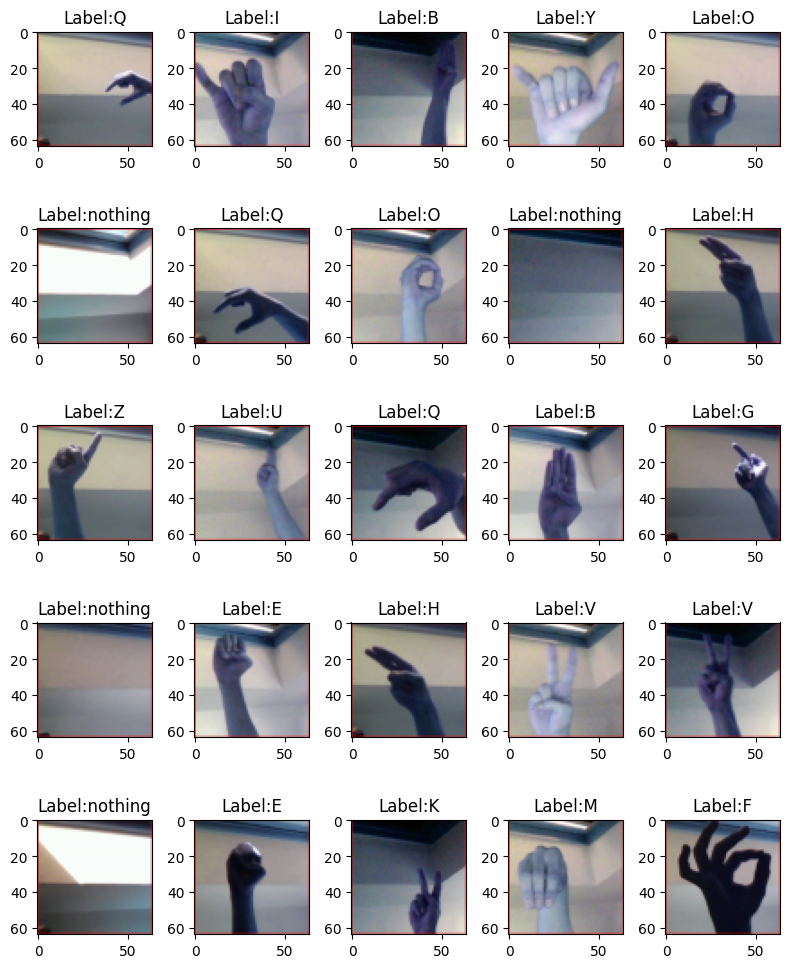

In [7]:
import matplotlib.pyplot as plt


data = next(iter(train_loader))


X = data[0]
Y = data[1]
print("Shape of X [N, C, H, W]:", X.shape)
print("Shape of Y:", Y.shape)
plt.figure(figsize=(8,10))
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del','nothing', 'space']

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i])
    plt.title("Label:%s" %classes[Y[i].item()])


plt.tight_layout()
plt.show()


In [8]:
from torch import nn

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = nn.Flatten()
    self.input_layer = nn.Sequential(
                       nn.Linear(3*64*64, 4096),
                       nn.BatchNorm1d(4096),
                       nn.ReLU(),
                       nn.Dropout(p=0.3)
                       )
    self.hidden_layer = nn.Sequential(
                        nn.Linear(4096,512),
                        nn.BatchNorm1d(512),
                        nn.ReLU(),
                        nn.Dropout(p=0.3))

    self.output_layer = nn.Linear(512, 29)

  def forward(self, x):
    x = self.flatten(x)
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    logits = self.output_layer(x)

    return logits

In [9]:
def train(dataloader, model, loss_fn, optimizer, device):
  model.train()

  for step, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.type(torch.long).to(device)

    optimizer.zero_grad()

    logits = model(X)

    loss = loss_fn(logits, y)

    loss.backward()
    optimizer.step()

  return model

In [10]:
def reshape_list(in_list):
  output_list = []
  b = len(in_list)
  for i in range(b):
    r, c = np.shape(in_list[i])
    for j in range(r):
      output_list.append(in_list[i][j])

  return output_list
def test(dataloader, model, loss_fn, device):
  test_loss = 0.0
  prob_list = []
  pred_list = np.array([])
  label_list = np.array([])

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      logits = model(X)

      loss = loss_fn(logits, y)

      test_loss += loss.item()


      prob = torch.softmax(logits, 1)
      prob_list.append(prob.cpu().numpy())
      pred_list = np.concatenate((pred_list, torch.argmax(prob, dim=1).cpu().numpy()))
      label_list = np.concatenate((label_list, y.cpu().numpy()))

    test_loss /= len(dataloader)

    return reshape_list(prob_list), pred_list, label_list, test_loss

In [11]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using %s device" %device)

model = MLP().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5

Using cuda device


In [12]:
import tqdm
import numpy as np
from sklearn import metrics


train_hist = []
test_hist = []

for e in tqdm.tqdm(range(epochs)):

  model = train(train_loader, model, loss_fn, optimizer, device)

  train_prob_list, train_pred_list, train_label_list, train_loss = test(train_loader, model, loss_fn, device)
  train_f1 = metrics.f1_score(train_label_list, train_pred_list, average="weighted")


  test_prob_list, test_pred_list, test_label_list, test_loss = test(test_loader, model, loss_fn, device)
  test_f1 = metrics.f1_score(test_label_list, test_pred_list, average="weighted")

  train_hist.append([train_loss, train_f1])
  test_hist.append([test_loss, test_f1])

print(e)

100%|██████████| 5/5 [01:43<00:00, 20.73s/it]

4


In [13]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del','nothing', 'space']
print("Train Set")
print(metrics.classification_report(train_label_list, train_pred_list, target_names=[str(item) for item in classes]))
print("\nTest Set")
print(metrics.classification_report(test_label_list, test_pred_list, target_names= [str(item) for item in classes]))

Train Set
              precision    recall  f1-score   support

           A       0.85      0.81      0.83      2416
           B       0.92      0.79      0.85      2401
           C       0.71      0.94      0.81      2374
           D       0.81      0.81      0.81      2415
           E       0.81      0.79      0.80      2414
           F       0.92      0.83      0.87      2432
           G       0.84      0.86      0.85      2397
           H       0.88      0.90      0.89      2402
           I       0.92      0.83      0.87      2420
           J       0.94      0.88      0.91      2420
           K       0.89      0.87      0.88      2383
           L       0.80      0.91      0.85      2398
           M       0.82      0.80      0.81      2404
           N       0.93      0.90      0.91      2416
           O       0.87      0.85      0.86      2381
           P       0.93      0.88      0.91      2426
           Q       0.91      0.93      0.92      2432
           R     

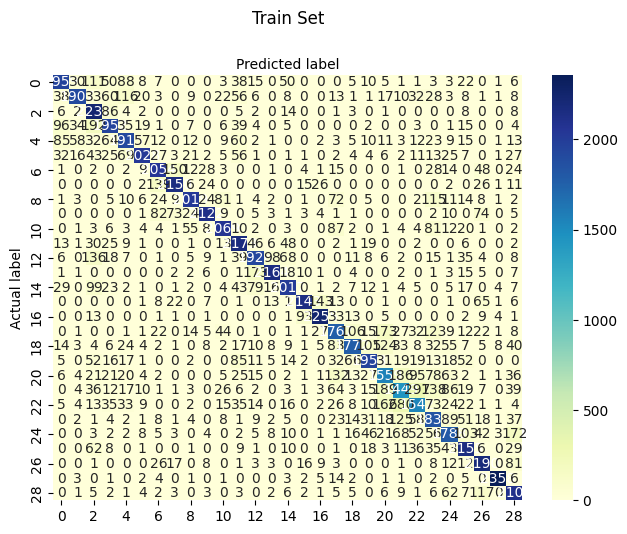

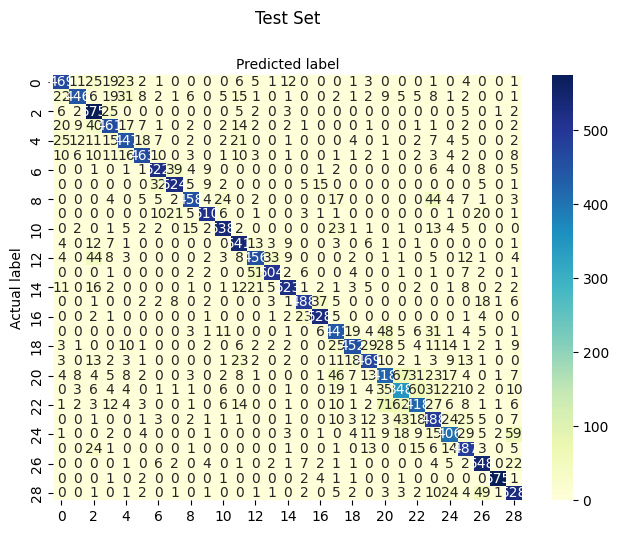

In [14]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def display_confusion_matrix(pred_list, label_list, class_names, title='train set'):
  cnf_matrix_train = metrics.confusion_matrix(pred_list, label_list)

  fig, ax =  plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix_train), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title(title, y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

display_confusion_matrix(train_label_list, train_pred_list, classes, title='Train Set')
display_confusion_matrix(test_label_list, test_pred_list, classes, title='Test Set')

Text(0.5, 0, 'Epochs')

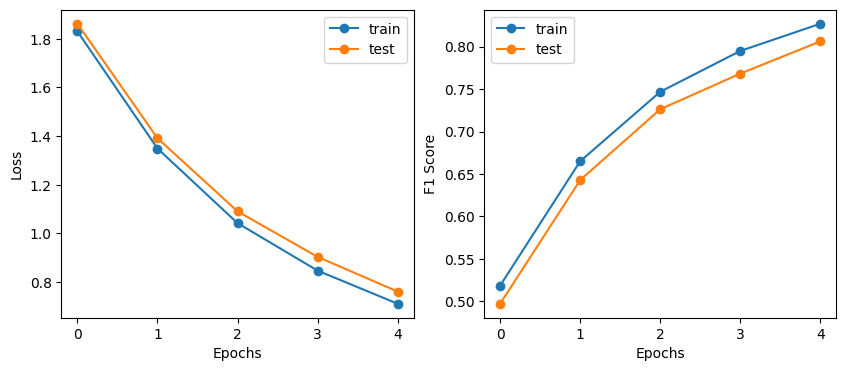

In [15]:
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

fontsize = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_hist[:,0], "-o")
plt.plot(test_hist[:,0], "-o")
plt.legend(("train", "test"))
plt.ylabel("Loss", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

plt.subplot(1,2,2)
plt.plot(train_hist[:,1], "-o")
plt.plot(test_hist[:,1], "-o")
plt.legend(("train", "test"))
plt.ylabel("F1 Score", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

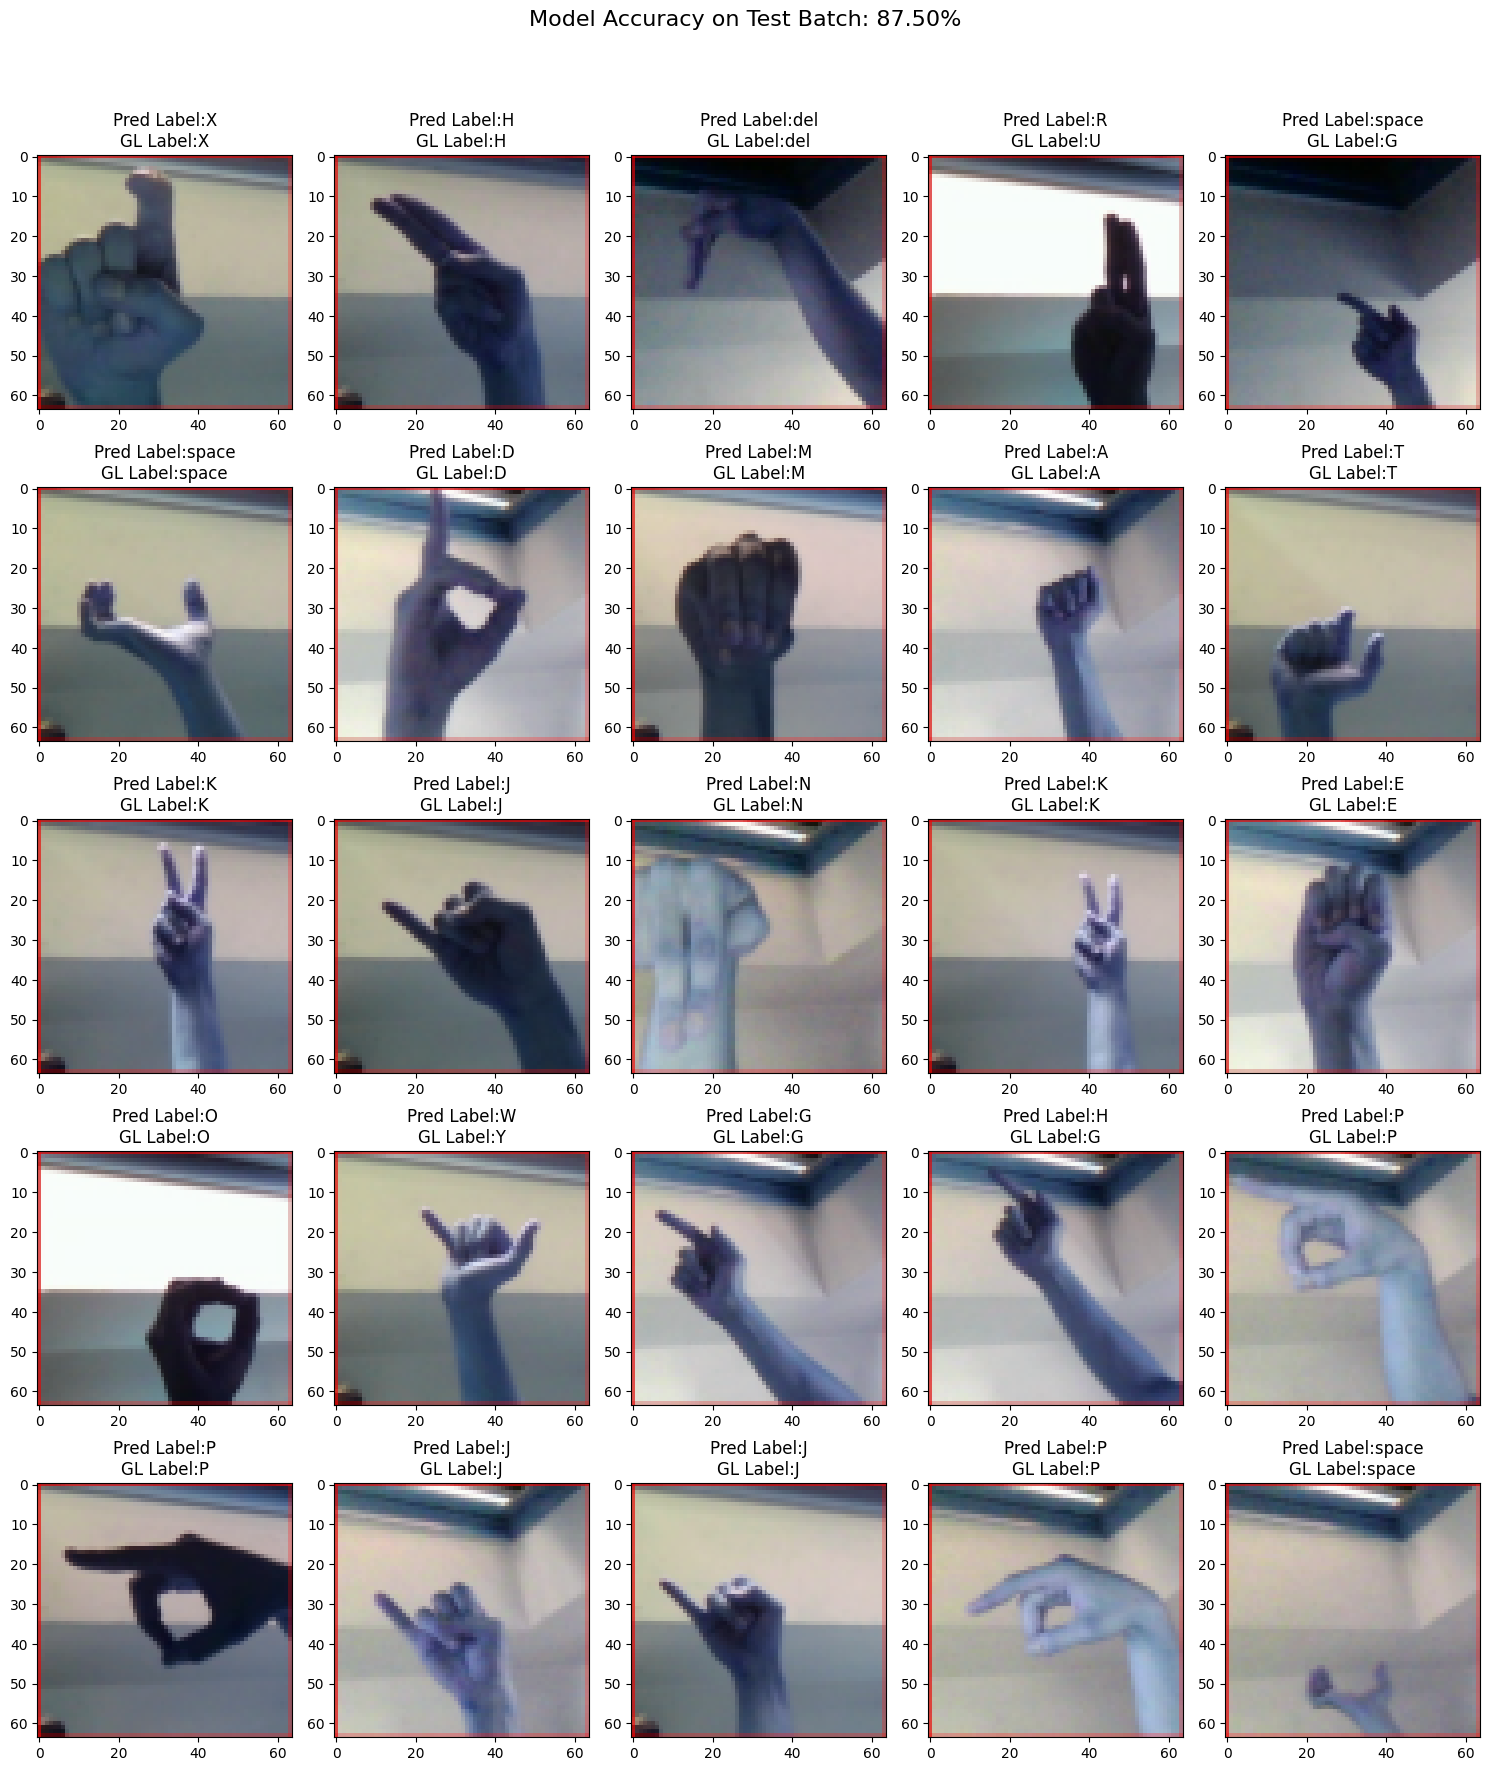

In [19]:

model.eval()
model = model.to("cuda")

correct = 0
total = 0

for X, y in test_loader:
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model(X)
    pred_labels = pred.argmax(1)
  correct += (pred_labels == y).sum().item()
  total += y.size(0)
  break

plt.figure(figsize=(15,18))
for i in range(25):
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(X[i].cpu().numpy(), cmap="gray")
  plt.title('Pred Label:%s\nGL Label:%s' %(classes[y_hat], classes[y_gt]))
accuracy = correct / total * 100

plt.suptitle(f"Model Accuracy on Test Batch: {accuracy:.2f}%", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
